# Neural Networks for Data Science Applications
## Experimenting with continual learning


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras import layers

import pandas as pd
import numpy as np
from tensorflow.keras import losses, optimizers, metrics, callbacks


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

**DESCRIPTION OF THE CODE**

The dataset with which this project will be developed was taken from Kaggle, uploading it directly to Colab for the first part, and then going local first (for some modifications) and then on the drive, for the Continual Learning part.

Link to the data: [https://www.kaggle.com/gpiosenka/sports-classification](https://www.kaggle.com/gpiosenka/sports-classification)

The dataset contains images of 100 different sports and can be used for an image classification problem. The size of the images is 256x256 pixels with 3 channels. It is a pretty clean dataset and it is possible to reach models with 95 - 98 % accuracy according to the description. There are no bad images or duplications and it is already splitted in train, test and validation sets. ( A bit unbalanced in favour of training set).


### Part 1: Convolutional Neural Network for Image Classification

#### Import the dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [ ]:
# Download the dataset from Kaggle directly (Output cancelled for clearness in the code)
!kaggle datasets download -d gpiosenka/sports-classification 

In [ ]:
# Unfip the folders (Output cancelled for clearness in the code)
!unzip sports-classification.zip

In [ ]:
# Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

#Load the data and infer directly the class of images from the name of directory + automathic map with integers

df_train = tf.keras.utils.image_dataset_from_directory('/content/train', labels='inferred', batch_size=32) #we already import images with batch size = 32 by defalut
df_val = tf.keras.utils.image_dataset_from_directory('/content/valid', labels='inferred',batch_size=32)
df_test = tf.keras.utils.image_dataset_from_directory('/content/test', labels='inferred',batch_size=32)

Found 13572 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [ ]:
print('This is the total number of batches (size 32) in the train_set: ', len(df_train))

This is the total number of batches (size 32) in the train_set:  425


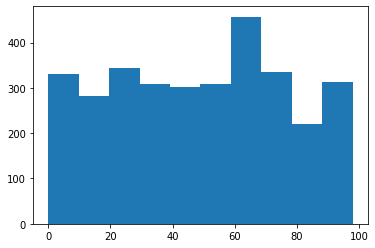

In [ ]:
#Check how balanced are the classes in the trainset

_tot = []
y_tot = []
for i in range(0,100): #Just check 100 batches

  _, y = next(iter(df_train))
  _tot.append(_)
  y_tot.append(y)

flat_list_x = [item for sublist in _tot for item in sublist]
flat_list_y = [item for sublist in y_tot for item in sublist]

flat_list_x = plt.hist(flat_list_y)

The classes looks pretty balanced


#### Let's define some function in order to preprocess the data

In [ ]:
#Casting of the variables

def preprocess(x, y):
  return tf.cast(x, tf.float32) / 255.0, y

In [ ]:
#Augmentation to improve the numbers of data point and make a more robust model

def augment(x, y):
  x = tf.image.random_brightness(x, 0.1)
  x = tf.image.random_flip_left_right(x)
  #x = tf.image.random_flip_up_down (x) ...we could add more to improve accuracy and mak the model more robust
  return x, y

In [ ]:
#Apply pre-precession to the data

df_train_it = \
  df_train.map(preprocess).shuffle(1000).take(340).map(augment).prefetch(tf.data.AUTOTUNE) #We choose 340 for memory limits 
df_val_it = \
  df_val.map(preprocess).prefetch(tf.data.AUTOTUNE)
df_test_it = \
  df_test.map(preprocess).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(df_train_it)

340

In [ ]:
#Check the shape
xb, yb = next(iter(df_train_it))
xb.shape

TensorShape([32, 256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


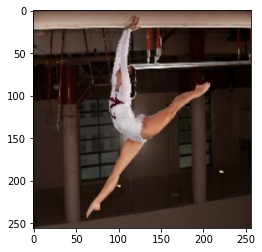

In [ ]:
#Example img
plt.imshow(xb[22])

### Train the dataset


**DESCRIPTION OF THE CODE**: 

The model created is based on a VGG-11 Architecture, so it will have two convolutional blocks with just one convolutional layer and three blocks with two convolutional layer. Then there is a fully-connected part to address the classification problems, but the number of neurons is smaller compared to the classic model, in order to avoid a too big number of parameters to train.

As output there are 100 different classes that our model should be able to predict and classify.
To send data in the fully connected part will be used a GlobalAveragePooling and dropout functions to regularize the model.

In [ ]:
#Let's try to define a classic VGG-11 Architecture with the add of Batchnormalization layers

In [ ]:
inp = layers.Input(shape=(256, 256, 3)) #Pixels 256x256, 3 channels

In [ ]:
def add_block(x, n_conv_layers, n_filters, use_max_pooling=True):

    for i in range(n_conv_layers):
        x = layers.Conv2D(n_filters, 3, padding='SAME', 
                          kernel_regularizer=regularizers.L2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    if use_max_pooling:
        x = layers.MaxPool2D(strides =2)(x)
    
    return x

def build_model():
    

    #First 2 block with just one convolutional layer
    x = add_block(inp, n_conv_layers=1, n_filters=16)
    x = add_block(x, n_conv_layers=1, n_filters=32)

    #Following blocks with 2 convolutional layers
    x = add_block(x, n_conv_layers=1, n_filters=32)
    x = add_block(x, n_conv_layers=2, n_filters=64)
    x = add_block(x, n_conv_layers=1, n_filters=64) #We stop at 64 because of the number of parameters is very high and I saw problems with Colab-runtime

    #Fully connected part
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(150, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    y = layers.Dense(100)(x) #The dataset has continous online upgrade, actually the class are 100, so this is the output layer.
    return Model(inputs=inp, outputs=y)

In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640  

In [ ]:
#Training and evaluation

In [ ]:
#Compile...

model.compile( 
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=[metrics.SparseCategoricalAccuracy()]
 )

In [ ]:
#...let's define some callbacks...

cbs = [
       callbacks.TerminateOnNaN(),
       callbacks.EarlyStopping(
           monitor='val_sparse_categorical_accuracy',
           patience=23,
           restore_best_weights=True,
           verbose=1
       )
]

In [ ]:
#...And Fit() our model!

model.fit(  
    df_train_it,
    epochs=200,
    validation_data=df_val_it,
    callbacks=cbs
)

Epoch 1/200
340/340 [==============================] - 81s 110ms/step - loss: 4.4909 - sparse_categorical_accuracy: 0.0343 - val_loss: 4.3476 - val_sparse_categorical_accuracy: 0.0300
Epoch 2/200
340/340 [==============================] - 64s 107ms/step - loss: 4.0274 - sparse_categorical_accuracy: 0.0661 - val_loss: 3.7951 - val_sparse_categorical_accuracy: 0.0820
Epoch 3/200
340/340 [==============================] - 59s 106ms/step - loss: 3.8380 - sparse_categorical_accuracy: 0.0873 - val_loss: 5.0435 - val_sparse_categorical_accuracy: 0.0540
Epoch 4/200
340/340 [==============================] - 59s 106ms/step - loss: 3.6679 - sparse_categorical_accuracy: 0.1142 - val_loss: 3.7375 - val_sparse_categorical_accuracy: 0.1120
Epoch 5/200
340/340 [==============================] - 59s 106ms/step - loss: 3.5538 - sparse_categorical_accuracy: 0.1285 - val_loss: 3.4520 - val_sparse_categorical_accuracy: 0.1280
Epoch 6/200
340/340 [==============================] - 61s 109ms/step - loss: 3.

Text(0.5, 0, 'Epochs')

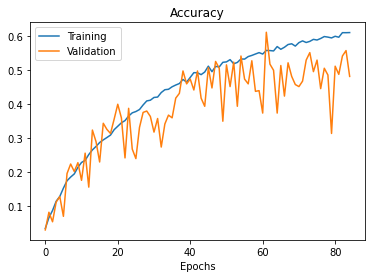

In [ ]:
plt.plot(model.history.history['sparse_categorical_accuracy'])
plt.plot(model.history.history['val_sparse_categorical_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

In [ ]:
model.evaluate(df_test_it)

16/16 [==============================] - 2s 54ms/step - loss: 1.5794 - sparse_categorical_accuracy: 0.6460


[1.5794011354446411, 0.6460000276565552]

The accuracy reached is not a great result, considering the prospective of the Dataset described in Kaggle.
We can try to improve it adding others way to augment the images, improving the number of epochs (like 200 or 300) and improving consequentially the 'patience' parameters in the callback (like 25 or 30 )

The run was very time-consuming so I decided to stop here.

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

## Part 2: Continual learning

Workflow:

* **Task-incremental learning**: split the dataset in > 2 task (e.g., dividing the outputs into disjoint subsets). The model will be a multi-head model
* Train the model on the tasks sequentially, using **elastic weight consolidation** (EWC).
* Show  the mean accuracy (as defined in the slides) and the backward transfer after training.


*Changes on the dataset*

In local, I modified the folders in order to split the tasks (3 tasks), then I uploaded the new directories on my Google-Drive and I read the datasets from there.

I created 3 different folders (one for each tasks), with 33 classes of images, splitting the initial folder of 100 classes and deleting one class of images. And I moved some images from the train set to test and validation set.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, we can consider the problem in this way:

**Task 1)** The Model should learn how to recognize and  classify 33 different classes of sport pictures

**Task 2)** The Model, remembering how to classify former classes, has to learn new 33 different classes

**Task 3)** The model should learn how to detect pictures others 33 different sports

#### Load and preprocess the new dataset

In [ ]:
# Split the dataset
n_tasks = 3

#Dataset for Task 1
df_train_task1 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task1_train',  labels='inferred',batch_size=32) 
df_val_task1 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task1_valid', labels='inferred',batch_size=32)
df_test_task1 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task1_test', labels='inferred',batch_size=32)
print('--------------------------')
#Dataset for Task 2
df_train_task2 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task2_train',  labels='inferred',batch_size=32) 
df_val_task2 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task2_valid', labels='inferred',batch_size=32)
df_test_task2 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task2_test', labels='inferred',batch_size=32)
print('--------------------------')

#Dataset for Task 3
df_train_task3 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task3_train',  labels='inferred',batch_size=32) 
df_val_task3 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task3_valid', labels='inferred',batch_size=32)
df_test_task3 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Continual_Learning2/task3_test', labels='inferred',batch_size=32)

Found 3559 files belonging to 33 classes.
Found 660 files belonging to 33 classes.
Found 660 files belonging to 33 classes.
--------------------------
Found 3476 files belonging to 33 classes.
Found 660 files belonging to 33 classes.
Found 660 files belonging to 33 classes.
--------------------------
Found 3479 files belonging to 33 classes.
Found 660 files belonging to 33 classes.
Found 660 files belonging to 33 classes.


In [ ]:
#Pre-processing data for task1

df_train_task1 = \
  df_train_task1.map(preprocess).shuffle(1000).map(augment).prefetch(tf.data.AUTOTUNE)
df_val_task1 = \
  df_val_task1.map(preprocess).prefetch(tf.data.AUTOTUNE)
df_test_task1 = \
  df_test_task1.map(preprocess).prefetch(tf.data.AUTOTUNE)
                                         
#Pre-processing data for task2

df_train_task2 = \
  df_train_task2.map(preprocess).shuffle(1000).map(augment).prefetch(tf.data.AUTOTUNE)
df_val_task2 = \
  df_val_task2.map(preprocess).prefetch(tf.data.AUTOTUNE)
df_test_task2 = \
  df_test_task2.map(preprocess).prefetch(tf.data.AUTOTUNE) 

#Pre-processing data for task1

df_train_task3 = \
  df_train_task3.map(preprocess).shuffle(1000).map(augment).prefetch(tf.data.AUTOTUNE)
df_val_task3 = \
  df_val_task3.map(preprocess).prefetch(tf.data.AUTOTUNE)
df_test_task3 = \
  df_test_task3.map(preprocess).prefetch(tf.data.AUTOTUNE)                                    

#### Create a new model

In [ ]:
#Let's define another model, simpler than the one in the point above

def add_block2(x, n_conv_layers=1, n_filters=32, use_max_pooling=True):

    for i in range(n_conv_layers):
        x = layers.Conv2D(n_filters, 3, padding='SAME', 
                          kernel_regularizer=regularizers.L2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    if use_max_pooling:
        x = layers.MaxPool2D(strides =2)(x)
    
    return x


def build_model():

    #2 block with just one convolutional layer
    inp = layers.Input(shape=(256, 256, 3))
    x = add_block2(inp, n_conv_layers=1, n_filters=32)
    x = add_block2(x, n_conv_layers=1, n_filters=64)
   
    #Fully connected part
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(250, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    #Head1
    h1 = layers.Dense(33 , activation ='softmax', name="head_1")(x)
    #Head2
    h2 = layers.Dense(33 , activation ='softmax', name="head_2")(x) 
    #Head3 
    h3 = layers.Dense(33 , activation ='softmax', name="head_3")(x) 
    return Model(inputs=inp, outputs=[h1, h2 , h3])

In [ ]:
# Define the multi-head model
# Tip: the functional API is pretty good here

model1 = build_model()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Now we compile and train the model on the first task ( df_train_task1)

In [ ]:
model1.compile( 
    loss=[losses.SparseCategoricalCrossentropy(from_logits=False), None , None] ,
    optimizer=optimizers.Adam(),
    metrics= [metrics.SparseCategoricalAccuracy()]
 )

In [ ]:
#...let's define some callbacks...

cbs2 = [
       callbacks.TerminateOnNaN(),
       callbacks.EarlyStopping(
           monitor='val_head_1_sparse_categorical_accuracy',
           patience=23,
           restore_best_weights=True,
           verbose=1
       )
]

cbs3 = [
       callbacks.TerminateOnNaN(),
       callbacks.EarlyStopping(
           monitor='val_head_2_sparse_categorical_accuracy',
           patience=23,
           restore_best_weights=True,
           verbose=1
       )
]

cbs4 = [
       callbacks.TerminateOnNaN(),
       callbacks.EarlyStopping(
           monitor='val_head_3_sparse_categorical_accuracy',
           patience=23,
           restore_best_weights=True,
           verbose=1
       )
]



In [ ]:
model1.fit(  
    df_train_task1,
    epochs=70,
    validation_data=df_val_task1,
    callbacks=cbs2
)

Epoch 1/70
112/112 [==============================] - 145s 1s/step - loss: 3.2961 - head_1_loss: 3.2503 - head_1_sparse_categorical_accuracy: 0.0905 - head_2_sparse_categorical_accuracy: 0.0301 - head_3_sparse_categorical_accuracy: 0.0332 - val_loss: 3.5280 - val_head_1_loss: 3.4845 - val_head_1_sparse_categorical_accuracy: 0.0333 - val_head_2_sparse_categorical_accuracy: 0.0258 - val_head_3_sparse_categorical_accuracy: 0.0409
Epoch 2/70
112/112 [==============================] - 26s 149ms/step - loss: 2.9629 - head_1_loss: 2.9208 - head_1_sparse_categorical_accuracy: 0.1498 - head_2_sparse_categorical_accuracy: 0.0261 - head_3_sparse_categorical_accuracy: 0.0461 - val_loss: 3.7097 - val_head_1_loss: 3.6689 - val_head_1_sparse_categorical_accuracy: 0.0394 - val_head_2_sparse_categorical_accuracy: 0.0303 - val_head_3_sparse_categorical_accuracy: 0.0394
Epoch 3/70
112/112 [==============================] - 26s 149ms/step - loss: 2.7751 - head_1_loss: 2.7353 - head_1_sparse_categorical_ac

In [ ]:
model1.save_weights('./drive/MyDrive/Colab Notebooks/checkpoints/weights1')

In [ ]:
model1_weights = model1.trainable_variables.copy()

In [ ]:
model1 = build_model()
model1.load_weights('./drive/MyDrive/Colab Notebooks/checkpoints/weights1')

Evaluation on different taks

In [ ]:
#Evaluation on task1 - testset
model1.evaluate(df_test_task1)

21/21 [==============================] - 100s 3s/step - loss: 2.0907 - head_1_loss: 2.0411 - head_1_sparse_categorical_accuracy: 0.4015 - head_2_sparse_categorical_accuracy: 0.0242 - head_3_sparse_categorical_accuracy: 0.0424


[2.0906546115875244,
 2.041149377822876,
 0.4015151560306549,
 0.024242423474788666,
 0.042424242943525314]

In [ ]:
#Evaluation on task2
model1.evaluate(df_test_task2)[0:3]

21/21 [==============================] - 99s 3s/step - loss: 7.0500 - head_1_loss: 7.0005 - head_1_sparse_categorical_accuracy: 0.0273 - head_2_sparse_categorical_accuracy: 0.0455 - head_3_sparse_categorical_accuracy: 0.0333


[7.050037860870361, 7.000533580780029, 0.027272727340459824]

In [ ]:
#Evaluation on task3
model1.evaluate(df_test_task3)[0:3]

21/21 [==============================] - 99s 3s/step - loss: 6.7527 - head_1_loss: 6.7032 - head_1_sparse_categorical_accuracy: 0.0364 - head_2_sparse_categorical_accuracy: 0.0061 - head_3_sparse_categorical_accuracy: 0.0152


[6.752744674682617, 6.703239440917969, 0.036363635212183]

#### Accuracy on task1 is around 40%. We have seen as the performance on task 2 and 3 are very bad,  training the model just one task 1. So now we try to train task2, avoiding *Catastrophic Forgetting*. The model should be able to predict the new classes(task2) but still aware of predictions on task1.


### Define the way to calculate Fisher information Matrix

In [ ]:
# Function to calculate Fisher information Matrix

def Fisher_m(model, df, num_batches, batch_size):  #We set the num_batches according to how many batches we have in the train set (in case of task1: 149)
  df = df.repeat()
  F = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables)}

  for i, (imgs, target) in enumerate(df.take(num_batches)):
    
    with tf.GradientTape() as tape:
      
      preds = model(imgs)
      ll = tf.nn.log_softmax(preds)

    ll_grads = tape.gradient(ll, model.trainable_variables) 

    # Compute F_i as mean of gradients squared
    for i, g in enumerate(ll_grads):
      F[i] += tf.math.reduce_mean(g ** 2, axis=0) / num_batches

  return F


In [ ]:
F = Fisher_m( model1 , df_train_task1 ,  112 , 32)  #112 batches in df_train_task1

In [ ]:
#Let's define the accuracy matrix from which at the end we will calculate GlobalAccuracy and BackwardTransfer
R = np.zeros((n_tasks, n_tasks))

#Let's add value that we already have available
R[0][0] = model1.evaluate(df_test_task1)[2]
R[1][0] = model1.evaluate(df_test_task2)[2]
R[2][0] = model1.evaluate(df_test_task3)[2]

21/21 [==============================] - 2s 82ms/step - loss: 6.7527 - head_1_loss: 6.7032 - head_1_sparse_categorical_accuracy: 0.0364 - head_2_sparse_categorical_accuracy: 0.0061 - head_3_sparse_categorical_accuracy: 0.0152


Now we have the model trained on task1, let's try to modify the loss function in order to keep the main weights of the first model and learn the task2 avoiding Catastrophic Forgetting

### Define a New Custom Loss Function in order to learn new parameters avoiding Catastrophic Forgetting

In [ ]:
class EWC(tf.keras.losses.Loss):
    def __init__(self, F, trainable_variables , old_weights, alpha = 25 ,  name="custom_mse"):
        super().__init__(name=name)
        self.F = F
        self.Theta = trainable_variables
        self.old_weights = old_weights
        self.alpha = alpha
        
    def call(self, y_true, y_pred):

        #Normal loss function to learn parameters on task2
        loss = losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred)
      
        #Way to calculate CL penalty
        penalty = 0
        for i, theta_i in enumerate(self.Theta):
          _penalty = tf.math.reduce_sum(self.F[i] * (theta_i - self.old_weights[i]) ** 2)
          penalty += _penalty

        #Final loss
        loss = loss + 0.5*self.alpha*penalty
        return loss

### **Train on Task2**

In [ ]:
model1.compile( 
    loss=[ None , EWC( F , model1.trainable_variables , model1_weights), None ] , 
    optimizer=optimizers.Adam(),
    metrics=[metrics.SparseCategoricalAccuracy() ]
 )

In [ ]:
model1.fit(  
    df_train_task2,
    epochs=70,
    validation_data=df_val_task2,
    callbacks=cbs3
)

Epoch 1/70
109/109 [==============================] - 623s 1s/step - loss: 3.2644 - head_2_loss: 3.2153 - head_1_sparse_categorical_accuracy: 0.0506 - head_2_sparse_categorical_accuracy: 0.1306 - head_3_sparse_categorical_accuracy: 0.0268 - val_loss: 3.0518 - val_head_2_loss: 3.0036 - val_head_1_sparse_categorical_accuracy: 0.0545 - val_head_2_sparse_categorical_accuracy: 0.1803 - val_head_3_sparse_categorical_accuracy: 0.0348
Epoch 2/70
109/109 [==============================] - 26s 151ms/step - loss: 2.7450 - head_2_loss: 2.6975 - head_1_sparse_categorical_accuracy: 0.0480 - head_2_sparse_categorical_accuracy: 0.2319 - head_3_sparse_categorical_accuracy: 0.0207 - val_loss: 2.6924 - val_head_2_loss: 2.6453 - val_head_1_sparse_categorical_accuracy: 0.0409 - val_head_2_sparse_categorical_accuracy: 0.2364 - val_head_3_sparse_categorical_accuracy: 0.0197
Epoch 3/70
109/109 [==============================] - 26s 152ms/step - loss: 2.4994 - head_2_loss: 2.4527 - head_1_sparse_categorical_ac

In [ ]:
model1_weights_2 = model1.trainable_variables.copy()

In [ ]:
model1.save_weights('./drive/MyDrive/Colab Notebooks/checkpoints/weights2')

#### **Considerations**

Now, in theory, the model should have learned to classify the images related to task2, remembering how to classify those of task1. We therefore expect the performance on task1 to be obviously worse than the previous training, but without Catastrophic Forgetting and the performance on task2 to be good, but not as good as the previous one we saw on task1, training the model only on the first dataset.

On task3, of course, we should have still very bad performance, because the model is not trained at all on that taks



In [ ]:
model1.evaluate(df_test_task1)

21/21 [==============================] - 3s 86ms/step - loss: 5.6513 - head_2_loss: 5.5995 - head_1_sparse_categorical_accuracy: 0.2348 - head_2_sparse_categorical_accuracy: 0.0227 - head_3_sparse_categorical_accuracy: 0.0273


[5.6512603759765625,
 5.599513530731201,
 0.2348484843969345,
 0.022727273404598236,
 0.027272727340459824]

In [ ]:
model1.evaluate(df_test_task2)

21/21 [==============================] - 2s 81ms/step - loss: 1.9674 - head_2_loss: 1.9156 - head_1_sparse_categorical_accuracy: 0.0409 - head_2_sparse_categorical_accuracy: 0.4364 - head_3_sparse_categorical_accuracy: 0.0152


[1.9673727750778198,
 1.9156266450881958,
 0.040909089148044586,
 0.4363636374473572,
 0.01515151560306549]

In [ ]:
model1.evaluate(df_test_task3)

21/21 [==============================] - 3s 84ms/step - loss: 5.8829 - head_2_loss: 5.8311 - head_1_sparse_categorical_accuracy: 0.0500 - head_2_sparse_categorical_accuracy: 0.0364 - head_3_sparse_categorical_accuracy: 0.0242


[5.882880687713623,
 5.831134796142578,
 0.05000000074505806,
 0.036363635212183,
 0.024242423474788666]

Although we have rather low absolute accuracy values, we can see the trend that was mentioned before

In [ ]:
#Let's update matrix - R

R[0][1] = model1.evaluate(df_test_task1)[2]
R[1][1] = model1.evaluate(df_test_task2)[3]
R[2][1] = model1.evaluate(df_test_task3)[3]

21/21 [==============================] - 2s 82ms/step - loss: 5.8829 - head_2_loss: 5.8311 - head_1_sparse_categorical_accuracy: 0.0500 - head_2_sparse_categorical_accuracy: 0.0364 - head_3_sparse_categorical_accuracy: 0.0242


**Accuracy on task1**: 0.2348

**Accuracy on task2**: 0.4364


### **Train on Task3**

In [ ]:
F2 = Fisher_m( model1 , df_train_task2 ,  109 , 32) #109 batches in df_train_task2

In [ ]:
model1.compile( 
    loss=[None , None , EWC( F2 , model1.trainable_variables , model1_weights_2)],
    optimizer=optimizers.Adam(),
    metrics=[metrics.SparseCategoricalAccuracy()]
 )

In [ ]:
model1.fit(  
    df_train_task3,
    epochs=70,
    validation_data=df_val_task3,
    callbacks=cbs4
)

Epoch 1/70
109/109 [==============================] - 644s 1s/step - loss: 3.2405 - head_3_loss: 3.1891 - head_1_sparse_categorical_accuracy: 0.0446 - head_2_sparse_categorical_accuracy: 0.0379 - head_3_sparse_categorical_accuracy: 0.1345 - val_loss: 2.9066 - val_head_3_loss: 2.8564 - val_head_1_sparse_categorical_accuracy: 0.0500 - val_head_2_sparse_categorical_accuracy: 0.0364 - val_head_3_sparse_categorical_accuracy: 0.1742
Epoch 2/70
109/109 [==============================] - 26s 152ms/step - loss: 2.6082 - head_3_loss: 2.5585 - head_1_sparse_categorical_accuracy: 0.0437 - head_2_sparse_categorical_accuracy: 0.0299 - head_3_sparse_categorical_accuracy: 0.2688 - val_loss: 2.5811 - val_head_3_loss: 2.5319 - val_head_1_sparse_categorical_accuracy: 0.0621 - val_head_2_sparse_categorical_accuracy: 0.0152 - val_head_3_sparse_categorical_accuracy: 0.2500
Epoch 3/70
109/109 [==============================] - 26s 151ms/step - loss: 2.3828 - head_3_loss: 2.3340 - head_1_sparse_categorical_ac

In [ ]:
model1.evaluate(df_test_task1)

21/21 [==============================] - 3s 86ms/step - loss: 5.9934 - head_3_loss: 5.9376 - head_1_sparse_categorical_accuracy: 0.1621 - head_2_sparse_categorical_accuracy: 0.0273 - head_3_sparse_categorical_accuracy: 0.0455


[5.993390083312988,
 5.9375715255737305,
 0.16212120652198792,
 0.027272727340459824,
 0.04545454680919647]

In [ ]:
model1.evaluate(df_test_task2)

21/21 [==============================] - 3s 91ms/step - loss: 6.3500 - head_3_loss: 6.2942 - head_1_sparse_categorical_accuracy: 0.0303 - head_2_sparse_categorical_accuracy: 0.2106 - head_3_sparse_categorical_accuracy: 0.0242


[6.3499956130981445,
 6.294177055358887,
 0.03030303120613098,
 0.21060605347156525,
 0.024242423474788666]

In [ ]:
model1.evaluate(df_test_task3)

21/21 [==============================] - 3s 86ms/step - loss: 1.8437 - head_3_loss: 1.7879 - head_1_sparse_categorical_accuracy: 0.0424 - head_2_sparse_categorical_accuracy: 0.0318 - head_3_sparse_categorical_accuracy: 0.4803


[1.8437355756759644,
 1.7879170179367065,
 0.042424242943525314,
 0.03181818127632141,
 0.480303019285202]

**Accuracy on task1**: 0.16

**Accuracy on task2**: 0.21

**Accuracy on task3**: 0.48

In [ ]:
#Let's update matrix - R

R[0][2] = model1.evaluate(df_test_task1)[2]
R[1][2] = model1.evaluate(df_test_task2)[3]
R[2][2] = model1.evaluate(df_test_task3)[4]

21/21 [==============================] - 3s 109ms/step - loss: 1.8437 - head_3_loss: 1.7879 - head_1_sparse_categorical_accuracy: 0.0424 - head_2_sparse_categorical_accuracy: 0.0318 - head_3_sparse_categorical_accuracy: 0.4803


In [ ]:
print(R)

[[0.40151516 0.23484848 0.16212121]
 [0.02727273 0.43636364 0.21060605]
 [0.03636364 0.03636364 0.48030302]]


#### BackwardTransfer and GlobalAccuracy

Now we can use some metrics to evaluate our Continual Learning Model

In [ ]:
#GlobalAccuracy from matrix R

global_accuracy = 0
for i in range(0,3):
  for j in range(0,3):
    if i <= j:
      global_accuracy = global_accuracy + R[i][j]

global_accuracy = global_accuracy/ (0.5*n_tasks*(n_tasks+1))
print('this is the Global accuracy: ' , round(global_accuracy,3))

this is the Global accuracy:  0.321


In [ ]:
# Backward_transfer from matrix R

backward_transfer = 0
for i in range(0,3):
  for j in range(0,3):
    if (i < j) & (j >= 2):
      backward_transfer = backward_transfer + (R[i][j] - R[i][i])

backward_transfer = backward_transfer/(0.5*n_tasks*(n_tasks - 1))
print('this is the Backward Transfer: ' , round(backward_transfer,3))

this is the Backward Transfer:  -0.155
